# Loan Payment Prediction 

## Problem definition:
---
[Lending Club](https://en.wikipedia.org/wiki/LendingClub) is a peer to peer lending company based in the United States, in which investors can search and browse the loan listings on LendingClub website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. The problem here is to find a loan which has a current status is a good loan or a bad loan, in other words good loans are those which are paid on time and bad loans are those which are paid late or never paid.


## Problems and Issues 
---
- Due to lack of powerful server and resources, we took undersampled the data set by uniform distributions. We picked up 100000 row from the data to work on the data, but to be sure of results, they should be tested by the whole data set.
- Another issue here was lack of deep knowledge about company terminology model which makes a little trouble to explore the data and choosing suitable features.
- We expected that the number of the states to be 50 (number of states in the united states) but it was 51 which is wrong.
- There are many null values for some features which makes them unuseful, therefore we ignore them.

## Define classification problem
---
We defined this problem as a classification problem, in which we want to predict the loan status by considering some features of each loan record. So we have two labels, good loans and bad loans.
Since there exists 9 class for each loan status in the data set, we only choose the lables as follows:


We have called the following label as good loan:
- Fully Paid

And all other labels as bad loans:
- Charged Off
- Does not meet the credit policy. Status:Charged Off
- In Grace Period
- Late (16-30 days)
- Late (31-120 days)
- Default

More details about labels are gathered in the following table:

| Loan status    | Label        | Description  |
| :------------- |:-------------|:-------------|
| Fully Paid      | Good | The loan is fully paid by the borrower |
| Charged Off     | Bad      |   When a creditor charges-off an account they are taking an account off of their accounting books that they assume will never get paid. |
| Does not meet the credit policy. Status:Charged Off| Bad      |   -|
| In Grace Period| Bad | A grace period is a set length of time after the due date during which payment may be made without penalty|
| Late (16-30 days)| Bad | - |
|Late (31-120 days)|    Bad | - |
| Default| Bad | Defaulting on a loan happens when repayments aren't made for a certain period of time. |


We try to solve the problem in the following sections:
1. Data Cleaning
2. Data Visualization
3. Feature Selection
4. Model Selection and Parameter Tuning
5. Results and Metrics

## Import libraries
---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC

# Clean the warning status in the notebook
warnings.filterwarnings('ignore')

# Set Pandas configurations to show data frames more widely
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Data Cleaning
---
1. Change the loan status in two classes, good loans and bad loans.
2. Remove the features which have more than 80 percent null values.
3. Remove the features which are highly correlated with other features. (A threshold of 95 percent correlation)
4. Remove the features which have more than 95 percent of zero values.
5. Create a new column and set the borrower's geographical region.
6. Clean the employee work experience columns.
7. Add a new column as year, to show the year of each loan.
8. Transform categorical data like credit score in a format to be acceptable by tree-related algorithms.
9. Remove dummy features.

In [66]:
# Read the data set
data = pd.read_csv('mini.csv')

def loan_status(status):
    """Divide loans to good loans and bad loans.
    
    Args:
        status: loan status
    
    Return:
        0: as bad loan status
        1: as good loan status 
    """
    good_loans = ["Fully Paid"]
    
    if status in good_loans:
        return 'Good'
    else:
        return 'Bad'

# Update loan_status feature in two predefined classes.
data['loan_status'] = data.loan_status.apply(loan_status)

# Drop columns which have more than 80 percent null values.
data.dropna(thresh=data.shape[0] * 0.8, axis=1, inplace=True)

# Drop the highly correlated features from the data set.
correlation_matrix = data.corr().abs()
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
highly_corr_cols = [c for c in upper.columns if any(upper[c] > 0.95)]

for col in highly_corr_cols:
    data = data.drop(col, axis=1)

# Drop columns which have more than 95 percent of zero values.
zero_columns = data.columns[(data == 0).sum() > 0.9 * data.shape[0]]

for col in zero_columns:
    data = data.drop(col, axis=1)

# Create the region column
def return_region(state):
    states_df = pd.read_csv('states.csv')
    return states_df[states_df['state_code'] == state]['division'].item()

data['region'] = data.addr_state.apply(return_region)
data = data.drop(['addr_state'], axis=1)

# Clean the employee length column
def transform_employee_length(year):
    if year == '< 1 year':
        return 0.5
    elif pd.isnull(year):
        return 0.5
    elif year == '10+ years':
        return 10
    else:
        return float(year.rstrip(' years'))

data['emp_length_num'] = data['emp_length'].map(transform_employee_length)
data = data.drop(['emp_length'], axis=1)

# Transform dates in a good format
data['issue_date'] = pd.to_datetime(data.issue_d).dt.year
data = data.drop(['issue_d'], axis=1)

data['earliest_cr_line'] = pd.to_datetime(data.earliest_cr_line).dt.year
data['earliest_cr_line'] = data.earliest_cr_line.astype(int)

data['last_credit_pull_date'] = pd.to_datetime(data.last_credit_pull_d).dt.year
data['last_credit_pull_date'] = data.last_credit_pull_date.fillna(0)
data['last_credit_pull_date'] = data.last_credit_pull_date.astype(int)
data = data.drop(['last_credit_pull_d'], axis=1)

data['last_pymnt_date'] = pd.to_datetime(data.last_pymnt_d).dt.year
data['last_pymnt_date'] = data.last_pymnt_date.fillna(0)
data['last_pymnt_date'] = data.last_pymnt_date.astype(int)
data = data.drop(['last_pymnt_d'], axis=1)

# Drop unuseful columns
drop_list = ['zip_code', 'sub_grade', 'Unnamed: 0', 'purpose', 'policy_code']
for col in drop_list:
    data = data.drop([col], axis=1)

## Data Visualization and EDA
---
In the Data Exploration step, we try to visualize and explore data, so we can have a better view of what we are working on, we want to know the answer of the following questions:

1. What is the distribution of loan amounts, interest rate?

2. What is the relationship among loan amounts, interest rate and loan status?

3. What is the most frequent employee length in the data set?

4. What are the labels and what is the distribution of loan status?

5. What is the term status/loan status relationship?

6. What is the loans issue data distribution?

7. Does home ownership affects on the loan repayment?

8. Which credit score is in the majority and which one is in the minority? and how this scores affect the loan repayment?

9. What is the relation among loan amount and grade score?

10. Why people need loans? what are their purposes to take a loan? does this affect to pay back the loan?

To answer these questions, read the following reports:

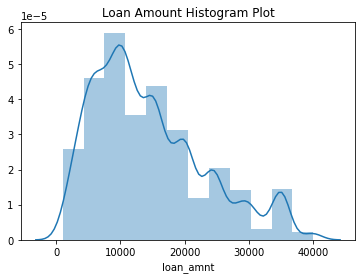

In [68]:
plt.title('Loan Amount Histogram Plot')
sns.distplot(data.loan_amnt, bins=12)

**Interpretation**

- From the plot it is obvious that the loans which are around $10000 are the most loans which are borrowed.

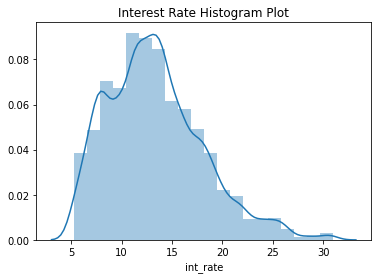

In [69]:
plt.title('Interest Rate Histogram Plot')
sns.distplot(data.int_rate, bins=20)

**Interpretation**

- From the plot interest rate around 10 and 15 are in the majority.
- Loans with more interest rates are not popular which is true observation.

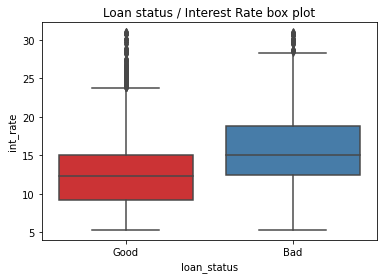

In [70]:
plt.title('Loan status / Interest Rate box plot')
sns.boxplot(x='loan_status',y='int_rate',data=data, palette='Set1')

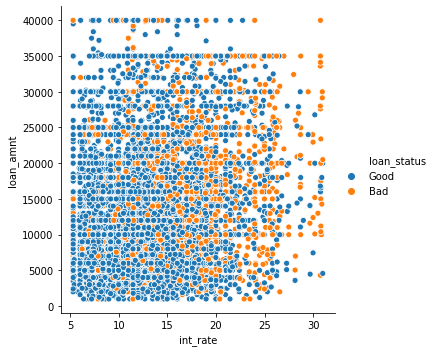

In [71]:
sns.relplot(x='int_rate', y='loan_amnt',  data=data, hue='loan_status')

**Interpretation**

- The chart illustrate that the increasment of a loan amount is relatively increases the interest rate and when a high loan amount with high interest rate leads to more bad loans.

[Text(0, 0.5, 'Percentage')]

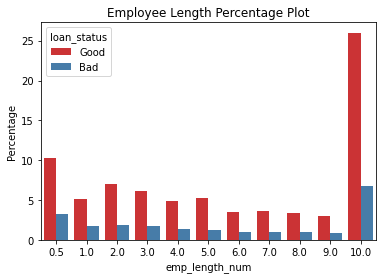

In [72]:
plt.title('Employee Length Percentage Plot')
employee_length_view = sns.barplot(x="emp_length_num",
                                   y=1,
                                   data=data,
                                   estimator=lambda x: len(x) / len(data) * 100,
                                   hue=data.loan_status,
                                   palette="Set1")
employee_length_view.set(ylabel="Percentage")

**Interpretation**

- Most of the borrowers are those who has more than 10 years of work experience.
- The differences among good loans and bad loans for those borrowers who have more than 10 years of work experience (about 20 percent) is more than other work experience buckets while in all other buckets the difference is less than 5 percent.

[Text(0, 0.5, 'Percentage')]

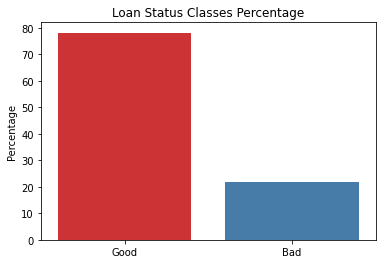

In [73]:
plt.title('Loan Status Classes Percentage')
class_percentage = data.loan_status.value_counts() / len(data) * 100
term_loan_view = sns.barplot(x=class_percentage.index, y=class_percentage,  palette="Set1")
term_loan_view.set(ylabel='Percentage')

**Interpretation**

- The plot shows that the good loans are in the majority. The data is very imbalanced. We will solve this issue with SMOTE algorithm in the next section.

[Text(0, 0.5, 'Percentage')]

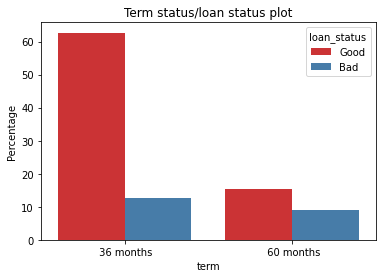

In [74]:
plt.title('Term status/loan status plot')
term_status_view = sns.barplot(x="term",
                               y=1,
                               data=data, 
                               estimator=lambda x: len(x) / len(data) * 100, 
                               hue='loan_status',
                               palette="Set1")
term_status_view.set(ylabel="Percentage")

**Interpretation**

- For 60 months loans, loan status are not very different. but for 36 months loans this difference is about 50 percent more for good loans.
- More of good loans are placed in 36 months loan terms.

[Text(0, 0.5, 'Percentage'), Text(0.5, 0, 'Issue Date')]

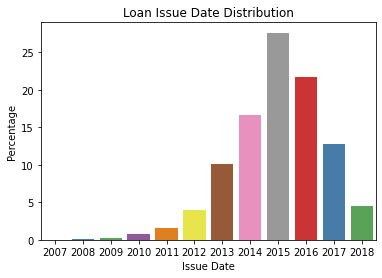

In [75]:
plt.title('Loan Issue Date Distribution')
issue_data_view = sns.barplot(x="issue_date",
                              y=1,
                              data=data, estimator=lambda x: len(x) / len(data) * 100, 
                              palette='Set1')
issue_data_view.set(ylabel="Percentage", xlabel='Issue Date')

**Interpretation**

- Number of granted loans have a uptrend behaviour until 2015, but it has a downtrend behaviour after it.

[Text(0, 0.5, 'Percentage'), Text(0.5, 0, 'Home Ownership')]

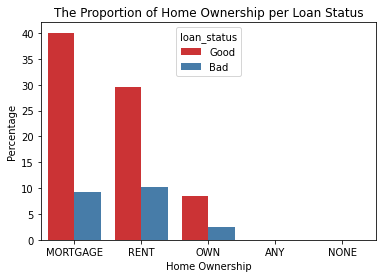

In [76]:
plt.title('The Proportion of Home Ownership per Loan Status')

home_ownership_loan_status_view = sns.barplot(x="home_ownership",
                                    y=1,
                                    data=data, 
                                    palette="Set1",
                                    estimator= lambda x: len(x) / len(data) * 100, hue='loan_status',
                                    )
home_ownership_loan_status_view.set(ylabel="Percentage", xlabel="Home Ownership")

**Interpretation**

- From the chart it could be understood loans which are granted to people who have their own house are less likely resulted to bad loans.
- If a borrower's home ownership is in mortgage or rent, the loan has the same chance to be a bad loan.

[Text(0, 0.5, 'Percentage'), Text(0.5, 0, 'Credit Score')]

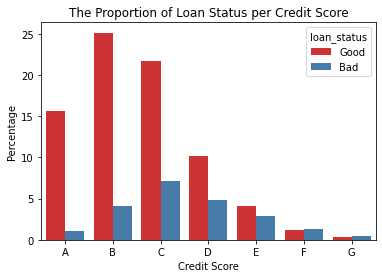

In [77]:
plt.title('The Proportion of Loan Status per Credit Score')
grade_percentage_view = sns.barplot(x="grade",
                                    y=1,
                                    data=data, 
                                    palette="Set1",
                                    estimator= lambda x: len(x) / len(data) * 100, hue='loan_status', 
                                    order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

grade_percentage_view.set(ylabel="Percentage", xlabel="Credit Score")

[Text(0, 0.5, 'Percentage'), Text(0.5, 0, 'Credit Score')]

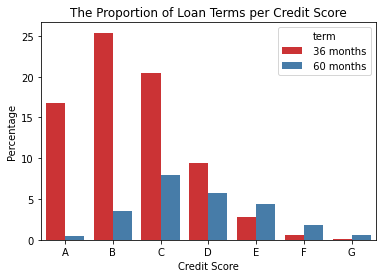

In [8]:
plt.title('The Proportion of Loan Terms per Credit Score')
grade_term_percentage = sns.barplot(x="grade",
                                    y=1,
                                    data=data, 
                                    palette="Set1",
                                    estimator= lambda x: len(x) / len(data) * 100, hue='term', 
                                    order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

grade_term_percentage.set(ylabel="Percentage", xlabel='Credit Score')

[Text(0, 0.5, 'Percentage'), Text(0.5, 0, 'Credit Score')]

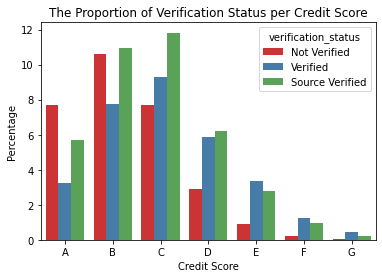

In [78]:
plt.title('The Proportion of Verification Status per Credit Score')
grade_verification_percentage = sns.barplot(x="grade",
                                    y=1,
                                    data=data, 
                                    palette="Set1",
                                    estimator= lambda x: len(x) / len(data) * 100, hue='verification_status', 
                                    order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
grade_verification_percentage.set(ylabel="Percentage", xlabel='Credit Score')

[Text(0, 0.5, 'Percentage'), Text(0.5, 0, 'Credit Score')]

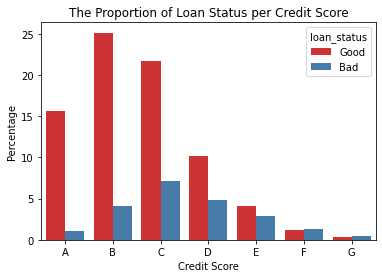

In [79]:
plt.title('The Proportion of Loan Status per Credit Score')
grade_loan_view = sns.barplot(x="grade",
                                    y=1,
                                    data=data, 
                                    palette="Set1",
                                    estimator= lambda x: len(x) / len(data) * 100, hue='loan_status', 
                                    order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
grade_loan_view.set(ylabel="Percentage", xlabel='Credit Score')

**Interpretation**

- The loans which are granted to people with higher credit scores are less likely to be a bad loan as well as loans which are granted to people with lower credit scores are less likely to be a good loan.
- The loans in the first four credit scores are most likely to repay, because most of the good loans are placed in these four buckets.
- The loans which are granted to a borrower with F and G-score is relatively risky to repay, Because people in the both scores are distributed almost equally. 
- The loans to a borrower with G-score is more risky to pay it back.
- The second chart shows that the people with higher credit score are willing to lower loan terms while people with lower credit score prefer the long loan terms.

In [81]:
# Create a new feature bucket for loan amount
data['loan_amnt_bucket'] = pd.cut(data.loan_amnt, list(range(0, 40000, 5000)))

cm = sns.light_palette("black", as_cmap=True)
pd.crosstab(data.loan_amnt_bucket, data.grade).apply(lambda r: r/r.sum()).style.background_gradient(cmap = cm)

grade,A,B,C,D,E,F,G
loan_amnt_bucket,,,,,,,
"(0, 5000]",0.113801,0.141229,0.149441,0.139597,0.0893617,0.0954357,0.0405405
"(5000, 10000]",0.328087,0.332182,0.279679,0.220134,0.178723,0.124481,0.0810811
"(10000, 15000]",0.20339,0.218923,0.220321,0.224161,0.204255,0.182573,0.216216
"(15000, 20000]",0.164044,0.15366,0.145251,0.159732,0.18156,0.186722,0.189189
"(20000, 25000]",0.118644,0.0808011,0.0963687,0.101342,0.126241,0.136929,0.162162
"(25000, 30000]",0.0508475,0.0393646,0.0436453,0.0744966,0.102128,0.112033,0.202703
"(30000, 35000]",0.0211864,0.0338398,0.0652933,0.0805369,0.11773,0.161826,0.108108


**Interpretation**

- From the chart it could be understood that people who has a better credit scores are willing to smaller loans and bad payers are those who takes bigger loan amounts.

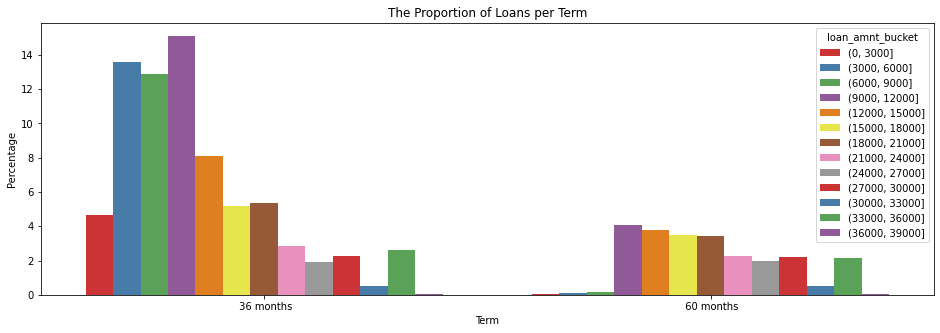

In [82]:
data['loan_amnt_bucket'] = pd.cut(data.loan_amnt, list(range(0, 40000, 3000)))


plt.figure(figsize=(16, 5))
plt.title('The Proportion of Loans per Term')
bucket_term_view = sns.barplot(x="term",
                               y=1,
                               data=data, 
                               palette="Set1",
                               estimator= lambda x: len(x) / len(data) * 100, hue='loan_amnt_bucket')
bucket_term_view.set(ylabel="Percentage", xlabel='Term')

# Delete the loan_amnt_bucket
data = data.drop(['loan_amnt_bucket'], axis=1)

**Interpretation**

- Most of the long period loans (60 months) have a higher amount, Most of them are above 10000 dollors, while 36 months loans have lower than 20000 dollors (above 70 percent)

## Data Cleaning (Handling null values)
- First of all we should illustrate the percentage of null values for each feature.
- Because we want to use the Random Forest algorithm, we can do is_null trick to handle null values. (creating a corresponding column to shows  But the problem is that we increase the number of features.

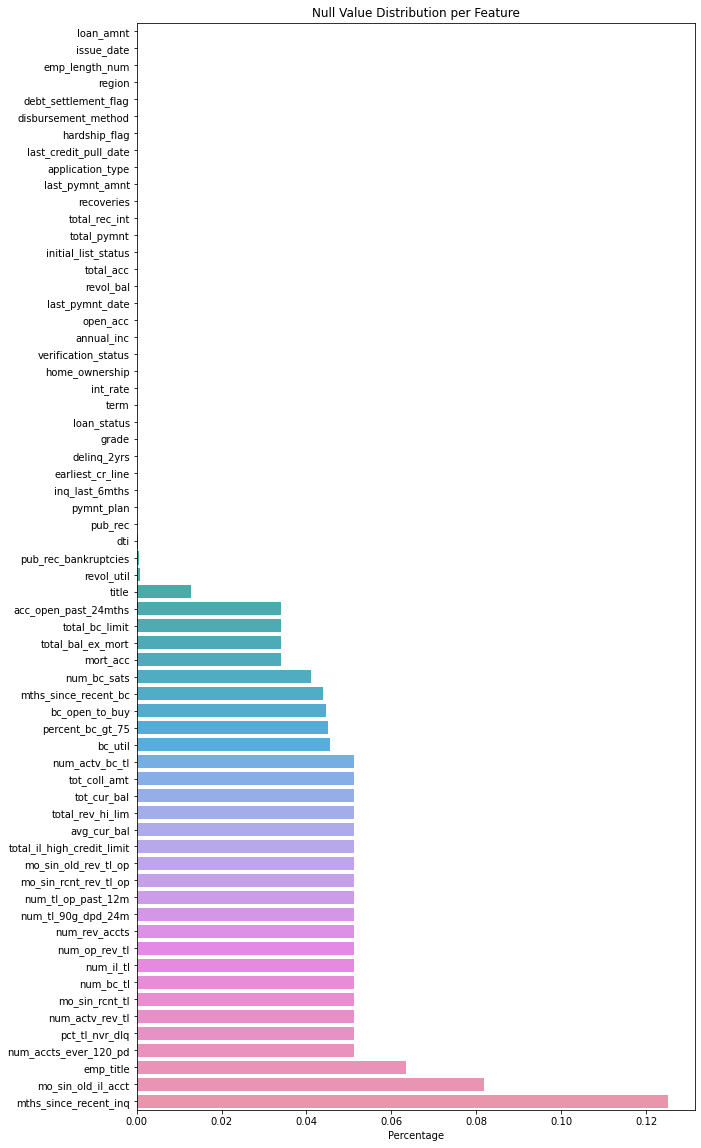

In [83]:
# Plot missing values informations
total = data.isnull().sum().sort_values(ascending=True)
percentage = (data.isnull().sum() / data.isnull().count()).sort_values()
missing_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Percentage'])
plt.figure(figsize=(10, 20))
plt.title('Null Value Distribution per Feature')
sns.barplot(x=missing_data.Percentage, y=missing_data.index)

In [84]:
# Finding categorical features from numericals
categoricals = ['debt_settlement_flag',
                'disbursement_method',
                'region',
                'initial_list_status',
                'home_ownership',
                'application_type',
                'hardship_flag',
                'verification_status',
                'title',
                'pymnt_plan',
                'emp_title',
                'grade',
                'term']

numericals = set(data.columns) - set(categoricals)
numericals = list(numericals)

In [85]:
# Columns with missing values
missing_value_columns = data.columns[data.isnull().any()]

# Replace null values with -999
for col in missing_value_columns:
    data[col].fillna(-999, inplace=True)
    
# Handling missing values in categorical columns
data['emp_title'].fillna('NULL', inplace=True)
data['title'].fillna('NULL', inplace=True)

## Model training
- Because there exist many categorical features in the dataset, we used Tree Algorithms (Random Forest in specific) which is a good algorithm to reach the mentioned goal.

In [94]:
# Hash all categorical features in the dataset
label_binarizer = LabelEncoder()
for col in categoricals:
    data[col] = data[col].astype(str)
    data[col] = label_binarizer.fit_transform(data[col])

In [15]:
# Handling dataset imbalancy using SMOTE
categorical_cols_index = [data.columns.get_loc(i) for i in categoricals]
smote = SMOTENC(categorical_features=categorical_cols_index, random_state = 2)
train_input, test_input, train_output, test_output = train_test_split(data[features], 
                                                                      data['loan_status'], 
                                                                      test_size = 0.3, 
                                                                      random_state = 0)
train_input, train_output = smote.fit_sample(train_input, train_output)

In [101]:
# Train model
features = set(data.columns) - set(['loan_status'])
model = RandomForestClassifier(n_estimators = 20, random_state = 31)
model.fit(train_input[features], train_output)

# Predict on testset
classes = model.predict(test_input[features])

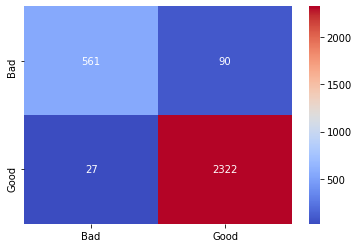

In [121]:
# Testset confusion matrix
labels = ['Bad', 'Good']
sns.heatmap(confusion_matrix(test_output, classes), cmap='coolwarm', annot=True, fmt='d',
           xticklabels=labels,
           yticklabels=labels)

In [103]:
# Testset classification reports
print(classification_report(test_output,
                            classes,
                            target_names=['Bad Loan', 'Good Loan']))

              precision    recall  f1-score   support

    Bad Loan       0.95      0.86      0.91       651
   Good Loan       0.96      0.99      0.98      2349

    accuracy                           0.96      3000
   macro avg       0.96      0.93      0.94      3000
weighted avg       0.96      0.96      0.96      3000



In [104]:
# Testset accuracy score
accuracy_score(test_output, classes)

0.961

## Feature Importance Distribution

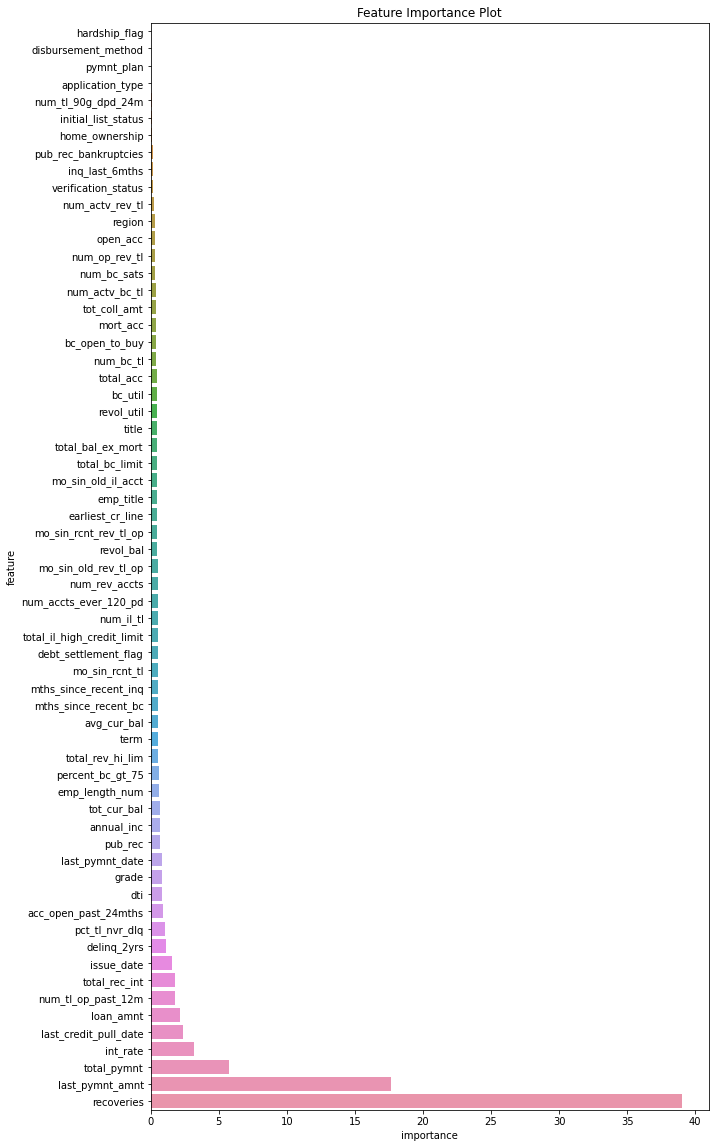

In [105]:
# Create a data frame of feature name and its importance on classifcation
importance_df = pd.DataFrame(columns=['feature', 'importance'], 
                             data=[[i, j] for i, j in zip(train_input[features].columns, 
                                                          model.feature_importances_)])
importance_df.sort_values(by='importance', inplace=True)
importance_df['importance'] = importance_df.importance * 100
plt.figure(figsize=(10, 20))
plt.title('Feature Importance Plot')
sns.barplot(x=importance_df.importance, y=importance_df.feature)

**Interpretation**

1. The ```recoveries```, ```last_pymnt_amnt```, ```total_pymnt``` and ```loan_amnt``` are very important in the classification.
2. Features like ```disbursement_method```, ```hardship_flag``` and ```pymnt_plan``` relatively have no effect on classification results, because of the extreme imbalancy in their values.
3. In order to using larger parts of dataset to learn the model, we can ignore the features which are less important for the classification algorithm.